<a href="https://colab.research.google.com/github/MattWroclaw/neural-networks/blob/main/06_cnn/02_binary_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Klasyfikator binarny - Image Classification - Drone vs. Passenger Plane

1. [Import bibliotek](#a0)
2. [Załadowanie danych](#a1)
3. [Przygotowanie zbiorów: treningowego, walidacyjnego i testowego](#a2)
4. [Eksplorcja danych](#a3)
5. [Augmentacja danych](#a4)
6. [Budowa modelu](#a5)
7. [Transfer learning - model VGG16](#a6)
8. [Transfer learning - model VGG16 - odmrożenie kilku ostatnich warstw](#a7)
9. [Ocena modelu na zbiorze testowym](#a8)
10. [Wyświetlenie błędów predykcji](#a9)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import TensorBoard

np.set_printoptions(precision=6, suppress=True)

### <a name='a1'></a> Załadowanie danych


In [2]:
# !wget https://storage.googleapis.com/esmartdata-courses-files/ann-course/flying-vehicles.zip
# !unzip -q flying-vehicles.zip

--2024-10-18 19:54:14--  https://storage.googleapis.com/esmartdata-courses-files/ann-course/flying-vehicles.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.217.207, 108.177.11.207, 108.177.12.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.217.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1540232238 (1.4G) [application/x-zip-compressed]
Saving to: ‘flying-vehicles.zip’

flying-vehicles.zip 100%[===================>]   1.43G  36.9MB/s    in 43s     

2024-10-18 19:54:58 (34.2 MB/s) - ‘flying-vehicles.zip’ saved [1540232238/1540232238]



### <a name='a2'></a> Przygotowanie zbiorów: treningowego, walidacyjnego i testowego

In [3]:
!rm -rf ./images

In [4]:
base_dir = './data/planes'
raw_no_of_files = {}
classes = ['drone', 'fighter-jet', 'helicopter', 'missile', 'passenger-plane', 'rocket']
for dir in classes:
    raw_no_of_files[dir] = len(os.listdir(os.path.join(base_dir, dir)))

raw_no_of_files.items()

dict_items([('drone', 1332), ('fighter-jet', 1867), ('helicopter', 1387), ('missile', 1334), ('passenger-plane', 1424), ('rocket', 1186)])

In [5]:
data_dir = './images'

if not os.path.exists(data_dir):
    os.mkdir(data_dir)

train_dir = os.path.join(data_dir, 'train')    # katalog zbioru treningowego
valid_dir = os.path.join(data_dir, 'valid')    # katalog zbioru walidacyjnego
test_dir = os.path.join(data_dir, 'test')      # katalog zbioru testowego

train_drone_dir = os.path.join(train_dir, 'drone')
train_passenger_dir = os.path.join(train_dir, 'passenger')

valid_drone_dir = os.path.join(valid_dir, 'drone')
valid_passenger_dir = os.path.join(valid_dir, 'passenger')

test_drone_dir = os.path.join(test_dir, 'drone')
test_passenger_dir = os.path.join(test_dir, 'passenger')

for directory in (train_dir, valid_dir, test_dir):
    if not os.path.exists(directory):
        os.mkdir(directory)

dirs = [train_drone_dir, train_passenger_dir, valid_drone_dir, valid_passenger_dir, test_drone_dir, test_passenger_dir]

for dir in dirs:
    if not os.path.exists(dir):
        os.mkdir(dir)

In [6]:
drone_fnames = os.listdir(os.path.join(base_dir, 'drone'))
passenger_fnames = os.listdir(os.path.join(base_dir, 'passenger-plane'))

drone_fnames = [fname for fname in drone_fnames if fname.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]
passenger_fnames = [fname for fname in passenger_fnames if fname.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]

In [8]:
size = min(len(drone_fnames), len(passenger_fnames)) # wybieramy mniejszy zbiór

train_size = int(np.floor(0.7 * size))
valid_size = int(np.floor(0.2 * size))
test_size = size - train_size - valid_size

train_idx = train_size
valid_idx = train_size + valid_size
test_idx = train_size + valid_size + test_size

In [10]:
for i, fname in enumerate(drone_fnames): #enumerate zwraca index i nazwę pliku

# dla dronów:
    if i <= train_idx:
        src = os.path.join(base_dir, 'drone', fname)  #base_dir = ./planes
        dst = os.path.join(train_drone_dir, fname) # train_drones= ./images/test/drones
        shutil.copyfile(src, dst)  # kopiowanie pliku z src do dst
    elif train_idx < i <= valid_idx:
        src = os.path.join(base_dir, 'drone', fname)
        dst = os.path.join(valid_drone_dir, fname)
        shutil.copyfile(src, dst)
    elif valid_idx < i < test_idx:
        src = os.path.join(base_dir, 'drone', fname)
        dst = os.path.join(test_drone_dir, fname)
        shutil.copyfile(src, dst)

# dla pasażerskich
for i, fname in enumerate(passenger_fnames):
    if i <= train_idx:
        src = os.path.join(base_dir, 'passenger-plane', fname)
        dst = os.path.join(train_passenger_dir, fname)
        shutil.copyfile(src, dst)
    elif train_idx < i <= valid_idx:
        src = os.path.join(base_dir, 'passenger-plane', fname)
        dst = os.path.join(valid_passenger_dir, fname)
        shutil.copyfile(src, dst)
    elif valid_idx < i < test_idx:
        src = os.path.join(base_dir, 'passenger-plane', fname)
        dst = os.path.join(test_passenger_dir, fname)
        shutil.copyfile(src, dst)

print('drone - zbiór treningowy', len(os.listdir(train_drone_dir)))
print('drone - zbiór walidacyjny', len(os.listdir(valid_drone_dir)))
print('drone - zbiór testowy', len(os.listdir(test_drone_dir)))

print('passenger - zbiór treningowy', len(os.listdir(train_passenger_dir)))
print('passenger - zbiór walidacyjny', len(os.listdir(valid_passenger_dir)))
print('passenger - zbiór testowy', len(os.listdir(test_passenger_dir)))

drone - zbiór treningowy 919
drone - zbiór walidacyjny 262
drone - zbiór testowy 131
passenger - zbiór treningowy 919
passenger - zbiór walidacyjny 262
passenger - zbiór testowy 131


### <a name='a3'></a> Eksplorcja danych

(-0.5, 1199.5, 629.5, -0.5)

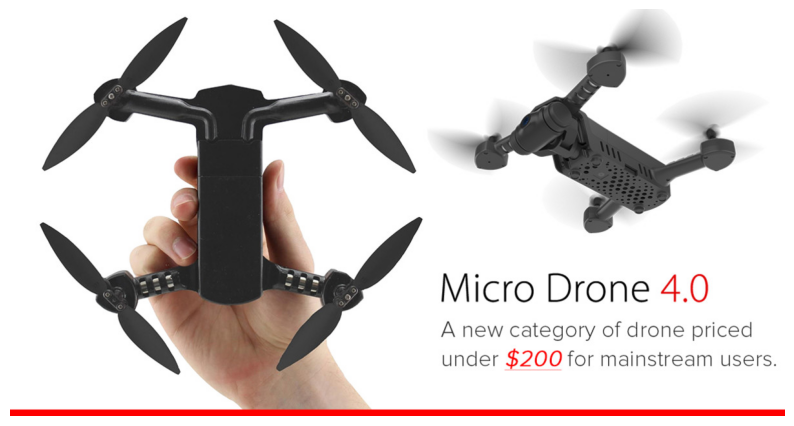

In [11]:
#@title Wybierz indeks przykładowego zdjęcia drona ze zbioru treningowego:

idx = 694 #@param {type:'slider', min:0, max:919}
names_mapping = dict(enumerate(drone_fnames))
img_path = os.path.join(train_drone_dir, names_mapping[idx])

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

(-0.5, 479.5, 319.5, -0.5)

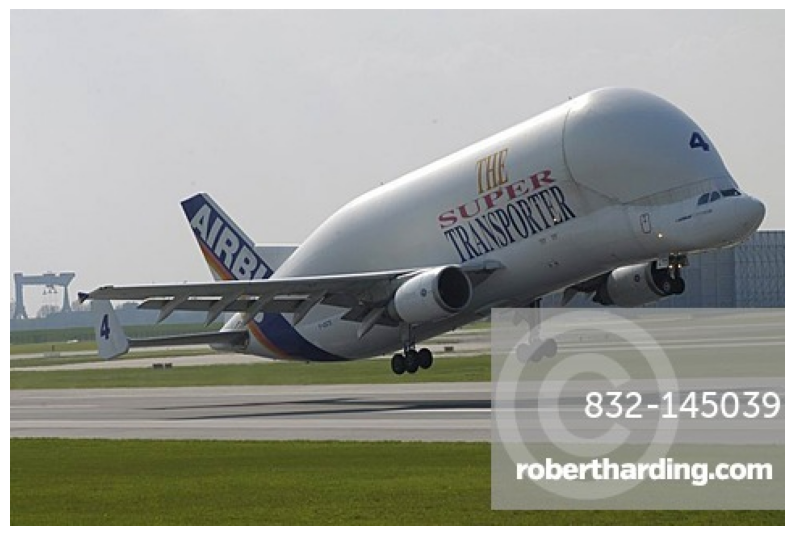

In [12]:
#@title Wybierz indeks przykładowego zdjęcia samolotu pasażerskiego ze zbioru treningowego:

idx = 699 #@param {type:'slider', min:0, max:919}
names_mapping = dict(enumerate(passenger_fnames))
img_path = os.path.join(train_passenger_dir, names_mapping[idx])

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

### <a name='a4'></a> Augmentcja danych
Ale tylko treningowych!!


In [13]:
train_datagen = ImageDataGenerator(
    rotation_range=40,     # zakres kąta o który losowo zostanie wykonany obrót obrazów
    rescale=1./255.,
    width_shift_range=0.2,  # pionowe przekształcenia obrazu
    height_shift_range=0.2, # poziome przekształcenia obrazu
    shear_range=0.2,        # zares losowego przycianania obrazu
    zoom_range=0.2,         # zakres losowego przybliżania obrazu
    horizontal_flip=True,   # losowe odbicie połowy obrazu w płaszczyźnie poziomej
    fill_mode='nearest'     # strategia wypełniania nowo utworzonych pikseli, któe mogą powstać w wyniku przekształceń
)

# przeskalowujemy wszystkie obrazy o współczynnik 1/255
valid_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(directory=train_dir, # nowe zdjęcia nie są zapisywane, są tworzone w locie
                                                   target_size=(150, 150),
                                                   batch_size=32,
                                                   class_mode='binary')

valid_generator = valid_datagen.flow_from_directory(directory=valid_dir,  # lokalizacja zbioru walidacyjnego
                                                   target_size=(150, 150),
                                                   batch_size=32,
                                                   class_mode='binary')

Found 1838 images belonging to 2 classes.
Found 524 images belonging to 2 classes.


In [17]:
def display_augmented_images(directory, idx):
    """
    Funkcja zwraca wykres przykładowych obrazów uzyskanych za pomocą techniki
    augmentacji danych.
    """
    fnames = [os.path.join(directory, fname) for fname in os.listdir(directory)]

    img_path = fnames[idx]
    img = image.load_img(img_path, target_size=(150, 150))

    x = image.img_to_array(img)
    x = x.reshape((1, ) + x.shape)

    i = 1
    plt.figure(figsize=(16, 8))
    for batch in train_datagen.flow(x, batch_size=1):
        plt.subplot(3, 4, i)
        plt.grid(False)
        imgplot = plt.imshow(image.array_to_img(batch[0]))
        i += 1
        if i % 13 == 0:
            break

Jeśli mamy katalog my_directory zawierający pliki file1.txt i file2.txt, to wynikowy kod:
```
python

fnames = [os.path.join('my_directory', fname) for fname in os.listdir('my_directory')]
```
zwróci listę:
```
python

['my_directory/file1.txt', 'my_directory/file2.txt']
```
To pozwala łatwo uzyskać pełne ścieżki do wszystkich plików w katalogu.

`img_to_array(img)`:

  Konwertuje obraz w formacie PIL (Python Imaging Library) lub innym zgodnym formacie na tablicę NumPy, która jest popularnym sposobem reprezentacji danych w formie macierzy w Pythonie. Taka tablica może być używana do obliczeń, np. w sieciach neuronowych.

  
Przykład:

Dla obrazu RGB o rozmiarach 256x256 pikseli, wynikowa tablica będzie miała wymiary (256, 256, 3), gdzie "3" odpowiada za trzy kanały koloru (R, G, B).

` x = x.reshape((1, ) + x.shape)`

Ten kod zmienia kształt (wymiary) tablicy x za pomocą metody reshape(), dodając nowy wymiar na początku. Oto co dokładnie robi:

  x.reshape((1, ) + x.shape):
        
        Funkcja reshape() zmienia kształt tablicy x na nowy wymiar.
        (1,) + x.shape:
            Tu dodawany jest nowy wymiar o rozmiarze 1 na początku istniejących wymiarów.
            x.shape to oryginalne wymiary tablicy x. Dzięki + wymiary oryginalne są dodawane do krotki (1,), co daje nowy kształt.

  Dodanie wymiaru:

        Jeśli pierwotnie x miało kształt (np. dla obrazu RGB o wymiarach 256x256): (256, 256, 3), to po przekształceniu będzie miało kształt: (1, 256, 256, 3).

  Dlaczego to robimy?:
  
        Dodanie wymiaru o rozmiarze 1 na początku tablicy jest często używane w sieciach neuronowych, gdzie modele wymagają, aby dane wejściowe miały kształt: (liczba przykładów, wysokość, szerokość, liczba kanałów).
        W tym przypadku, oryginalny obraz miał wymiary (wysokość, szerokość, liczba kanałów). Dodanie wymiaru 1 symuluje "partię" (batch) o wielkości 1, ponieważ algorytmy sieci neuronowych zazwyczaj przetwarzają obrazy w partiach.

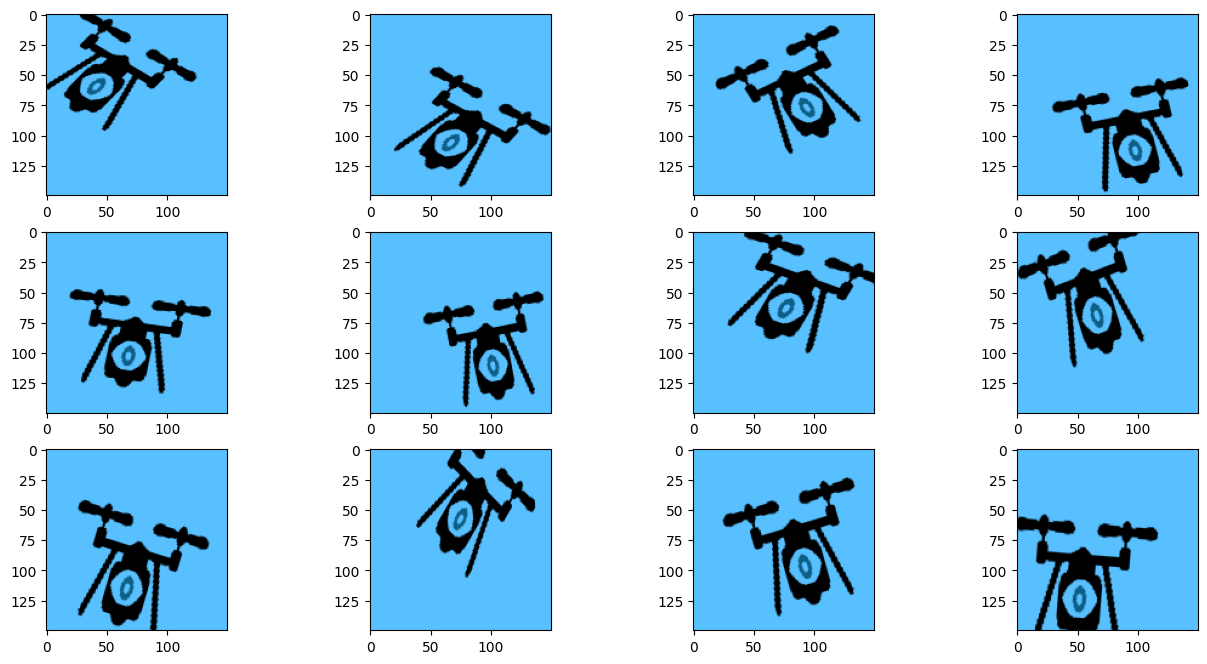

In [15]:
#@title Zbiór treningowy drone:
idx = 467 #@param {type:'slider', min:0, max:919}
display_augmented_images(train_drone_dir, idx)

['./images/train/passenger/00000366.jpg', './images/train/passenger/00000539.png', './images/train/passenger/00001343.jpg', './images/train/passenger/00000748.jpg', './images/train/passenger/00001229.jpg', './images/train/passenger/00001055.jpeg', './images/train/passenger/00000910.jpg', './images/train/passenger/00001417.jpg', './images/train/passenger/00000107.jpg', './images/train/passenger/00000057.jpg', './images/train/passenger/00000407.jpg', './images/train/passenger/00000849.jpg', './images/train/passenger/00000743.jpg', './images/train/passenger/00001066.jpg', './images/train/passenger/00000993.jpg', './images/train/passenger/00000904.jpg', './images/train/passenger/00001183.jpg', './images/train/passenger/00000123.jpg', './images/train/passenger/00000811.jpg', './images/train/passenger/00000918.jpg', './images/train/passenger/00001168.jpg', './images/train/passenger/00001218.jpg', './images/train/passenger/00001082.jpg', './images/train/passenger/00000974.jpg', './images/trai

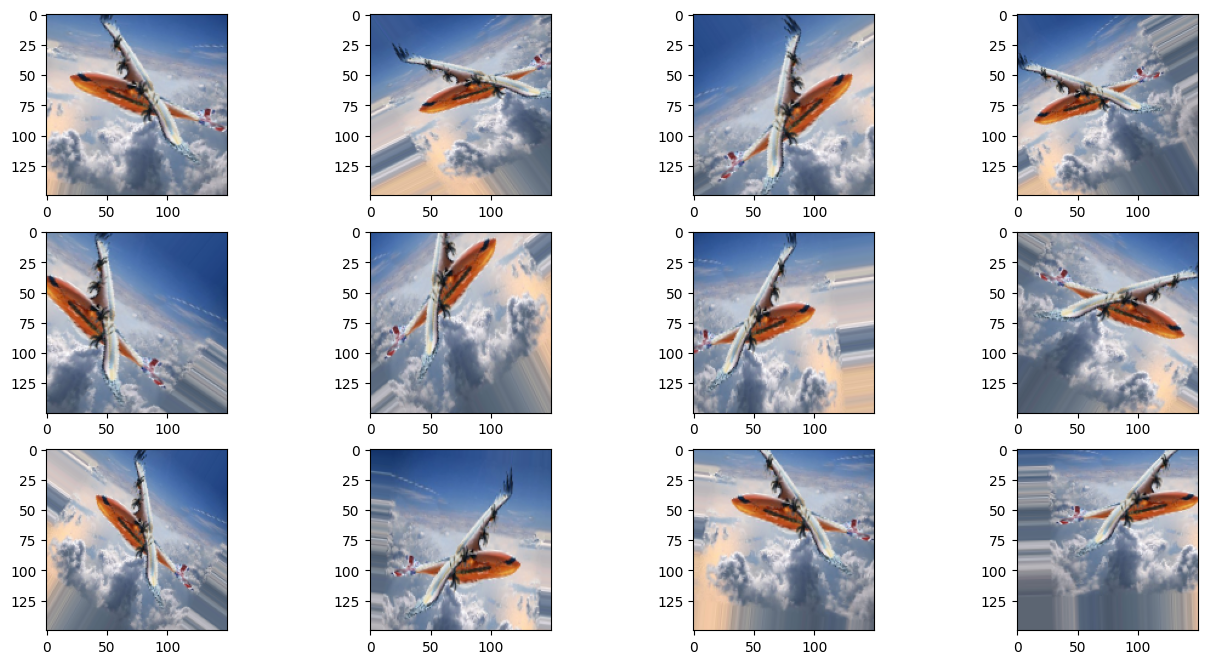

In [18]:
#@title Zbiór treningowy passenger:
idx = 111 #@param {type:'slider', min:0, max:919}
display_augmented_images(train_passenger_dir, idx)